In [84]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy 

In [13]:
df_usage = pd.read_csv('usage_cost.csv')

In [15]:
df_revenue = pd.read_csv('total_revenue.csv')

In [16]:
df_revenue = df_revenue.drop(['jan.1'], axis=1)

In [17]:
df_final = pd.merge(df_usage, df_revenue, on='accounts', how='outer')

In [22]:
df_final_sorted = df_final.sort_values(by=['June 2022'], ascending = False)

In [36]:
df_june = df_final_sorted[['accounts', 'June 2022', 'june']]

In [61]:
df_june = df_june.rename(columns={"June 2022": "June Cost", "june": "June Revenue"}, errors="raise")

In [64]:
df_june.head(20).style.format({"June Cost": "${:20,.0f}"})\
                 .format({"accounts": lambda x:x.lower()})\
                 .hide(axis='index')\
                 .background_gradient(cmap='Greens')

Correspondent,June Cost,June Revenue
gotr,57369.580000,3942.730000
stbt,27125.610000,1418.730000
indw,5720.290000,3501.390000
valb,5357.340000,207.790000
nano,2869.190000,36.720000
shrs,2608.310000,51.710000
srwa,2390.150000,3442.760000
mida,1270.030000,16549.420000
rasd,937.230000,30.260000
gild,846.330000,1.890000


<AxesSubplot:title={'center':'API Infra Cost vs Revenue Generated (June 2022)'}, xlabel='Correspondent', ylabel='Cost vs Revenue ($)'>

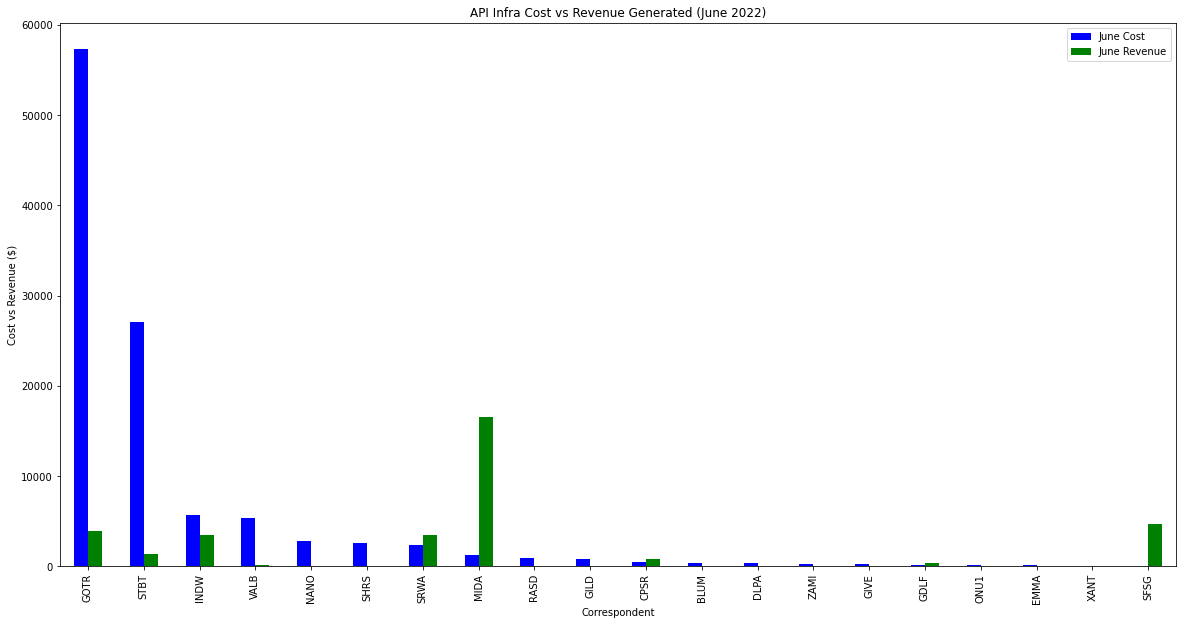

In [83]:
df_june.head(20).plot(kind="bar", x='accounts', color=['Blue', 'Green'],  figsize = (20, 10), xlabel = 'accounts', ylabel = 'Cost vs Revenue ($)', \
                      title = 'Product Infra Cost vs Revenue Generated (June 2022)')

In [85]:
engine = sqlalchemy.create_engine('postgres_URI')

In [88]:
query = """
select
--entity_for_exchange as broker,
accounts as accounts,
count(case when month_cd = '2022-01-01' then id end) as jan_executions,
count(case when month_cd = '2022-02-01' then id end) as feb_executions,
count(case when month_cd = '2022-03-01' then id end) as mar_executions,
count(case when month_cd = '2022-04-01' then id end) as apr_executions,
count(case when month_cd = '2022-05-01' then id end) as may_executions,
count(case when month_cd = '2022-06-01' then id end) as june_executions

from
(
select
id,
user_account,
accounts,
market_maker,
entity_for_exchange,
market_identifier_code,
exchange,
date_of_exchange,
month_cd,
shares_needed,
tif,
share_price,
pfof,
qty
    

from
(
select
a.id,
A.source,
B.user_account,
B.accounts,
A.market_maker,
D.entity_for_exchange,
C.exchange,
D.market_identifier_code,
A.extended_hours,
cast(a.filled_at as date) as date_of_exchange,
date_trunc('month',a.filled_at) as month_cd,
A.shares_needed,
A.share_price,
A.tif,
D.created_at_order,
D.created_at_order_ns,
D.qty
from orders A

join accounts B
on A.account = B.user_account

join assets C
on A.asset_id::uuid = C.id::uuid

join executions D
on A.id = D.order_id


where D.order_status like '%%filled%%'

) as aaa

) as aaa

group by
1
"""

In [89]:
df_executions = pd.read_sql_query(query, engine)

In [93]:
#df_executions.to_csv('executions_df.csv')

In [95]:
df_executions = df_executions.rename(columns={"accounts": "accounts"}, errors="raise")

In [115]:
df_executions_june = df_executions[['accounts', 'june_executions']]

In [117]:
df_june = pd.merge(df_june, df_executions_june, on='accounts', how='left')

In [119]:
df_june1 = df_june[['accounts', 'June Cost', 'june_executions']]

In [124]:
df_june1 = df_june1.head(20)

In [125]:
df_june1['Cost Product'] = df_june1['June Cost']/df_june1['june_executions']

/tmp/ipykernel_96/2505214156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_june1['Cost API'] = df_june1['June Cost']/df_june1['june_executions']


<AxesSubplot:title={'center':'API Infra Cost per Executed Trade (June 2022)'}, xlabel='Correspondent', ylabel='Cost per Executed Trade ($)'>

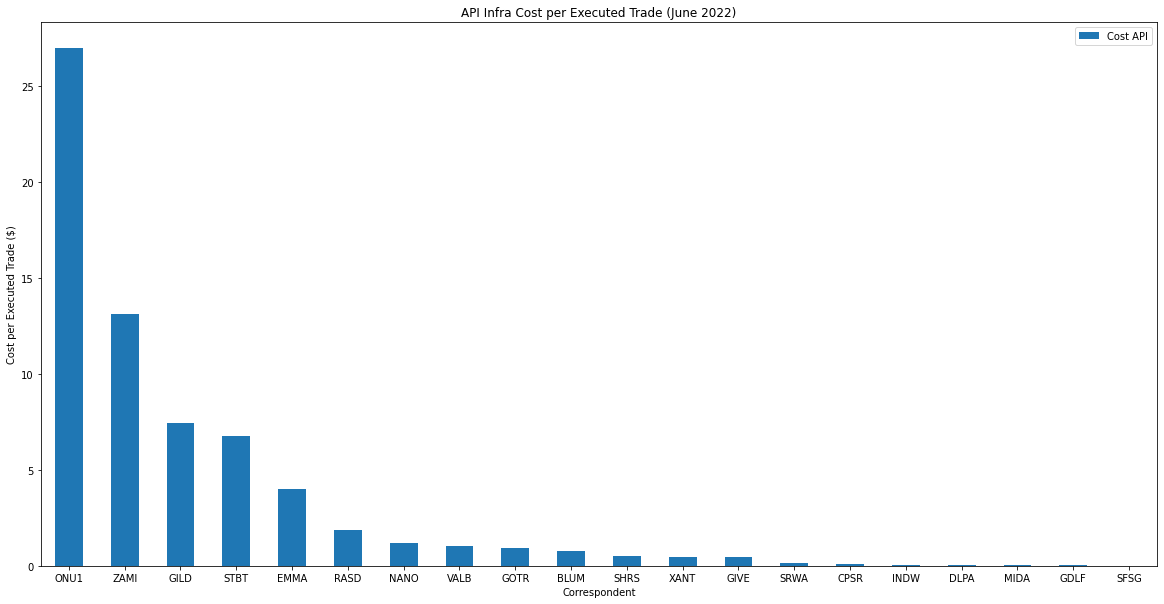

In [133]:
df_june1.sort_values(by=['Cost Product'], ascending = False).plot.bar(x='accounts', y='Cost Product', rot=0, figsize = (20, 10), xlabel = 'accounts', ylabel = 'Cost per Executed Trade ($)', \
                      title = 'Product Infra Cost per Executed Trade (June 2022)')

In [168]:
query2 = """
select
--entity_for_exchange as broker,
accounts as "accounts",
sum(case when month_cd = '2022-01-01' then qty end) as jan_shares,
sum(case when month_cd = '2022-02-01' then qty end) as feb_shares,
sum(case when month_cd = '2022-03-01' then qty end) as mar_shares,
sum(case when month_cd = '2022-04-01' then qty end) as apr_shares,
sum(case when month_cd = '2022-05-01' then qty end) as may_shares,
sum(case when month_cd = '2022-06-01' then qty end) as june_shares

from
(
select
id,
user_account,
accounts,
market_maker,
entity_for_exchange,
market_identifier_code,
exchange,
date_of_exchange,
month_cd,
shares_needed,
tif,
share_price,
pfof,
qty
    


from
(
select
a.id,
A.source,
B.user_account,
B.accounts,
A.market_maker,
D.entity_for_exchange,
C.exchange,
D.market_identifier_code,
A.extended_hours,
cast(a.filled_at as date) as date_of_exchange,
date_trunc('month',a.filled_at) as month_cd,
A.shares_needed,
A.share_price,
A.tif,
D.created_at_order,
D.created_at_order_ns,
D.qty,

from orders A

join accounts B
on A.account = B.user_account

join assets C
on A.asset_id::uuid = C.id::uuid

join executions D
on A.id = D.order_id
where D.order_status like '%%filled%%'
and D.entity_for_exchange in ('FTX','BINANCE','CREDITSUISSE')

) as aaa

) as aaa

group by
1
"""

In [169]:
df_shares = pd.read_sql_query(query2, engine)

In [175]:
df_shares_june = df_shares[['accounts', 'june_shares']]

In [176]:
df_june = pd.merge(df_june, df_shares_june, on='accounts', how='left')

In [177]:
df_june2 = df_june[['accounts', 'June Cost', 'june_shares']]

In [179]:
df_june2['Cost Product'] = df_june2['June Cost']/df_june2['june_shares']

/tmp/ipykernel_96/1740447594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_june2['Cost API'] = df_june2['June Cost']/df_june2['june_shares']


In [180]:
df_june2 = df_june2.head(20)

<AxesSubplot:title={'center':'API Infra Cost per Traded Share (June 2022)'}, xlabel='Correspondent', ylabel='Cost per Executed Trade ($)'>

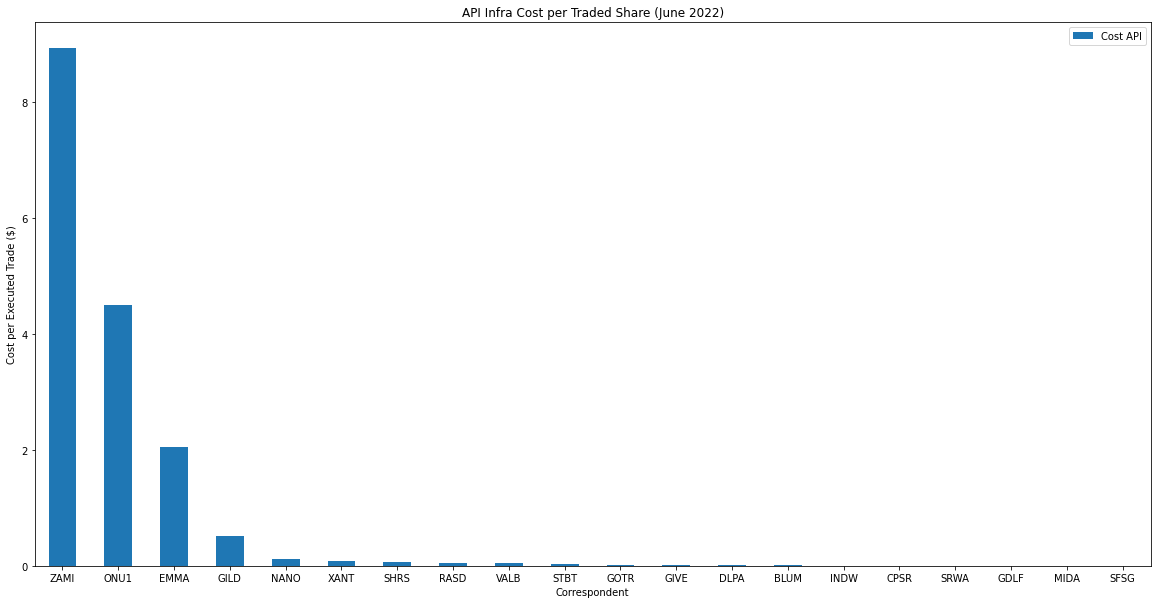

In [183]:
df_june2.sort_values(by=['Cost Product'], ascending = False).plot.bar(x='accounts', y='Cost Product', rot=0, figsize = (20, 10), xlabel = 'accounts', ylabel = 'Cost per Executed Trade ($)', \
                      title = 'Product Infra Cost per Traded Share (June 2022)')

In [1]:
query3 = """
select
--entity_for_exchange as broker,
accounts as "accounts",
count(distinct case when month_cd = '2022-01-01' then user_account end) as jan_accounts,
count(distinct case when month_cd = '2022-02-01' then user_account end) as feb_accounts,
count(distinct case when month_cd = '2022-03-01' then user_account end) as mar_accounts,
count(distinct case when month_cd = '2022-04-01' then user_account end) as apr_accounts,
count(distinct case when month_cd = '2022-05-01' then user_account end) as may_accounts,
count(distinct case when month_cd = '2022-06-01' then user_account end) as june_accounts

from
(
select
id,
user_account,
accounts,
market_maker,
entity_for_exchange,
market_identifier_code,
exchange,
date_of_exchange,
month_cd,
shares_needed,
tif,
share_price,
pfof,
qty
    

from
(
select
a.id,
A.source,
B.user_account,
B.accounts,
A.market_maker,
D.entity_for_exchange,
C.exchange,
D.market_identifier_code,
A.extended_hours,
cast(a.filled_at as date) as date_of_exchange,
date_trunc('month',a.filled_at) as month_cd,
A.shares_needed,
A.share_price,
A.tif,
D.created_at_order,
D.created_at_order_ns,
D.qty

from orders A

join accounts B
on A.account = B.user_account

join assets C
on A.asset_id::uuid = C.id::uuid

join executions D
on A.id = D.order_id

where D.order_status like '%%filled%%'
and D.entity_for_exchange in ('FTX','BINANCE','CREDITSUISSE')

) as aaa

) as aaa

group by
1
"""


In [2]:
df_accounts_traded = pd.read_sql_query(query3, engine)

NameError: name 'pd' is not defined

In [157]:
df_accounts_traded_june = df_accounts_traded[['accounts', 'june_accounts']]
df_june = pd.merge(df_june, df_accounts_traded_june, on='accounts', how='left')

In [159]:
df_june3 = df_june[['accounts', 'June Cost', 'june_accounts']]
df_june3['Cost Product'] = df_june3['June Cost']/df_june3['june_accounts']

/tmp/ipykernel_96/2140755766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_june3['Cost API'] = df_june3['June Cost']/df_june3['june_accounts']


In [160]:
df_june3 = df_june3.head(20)

In [3]:
df_june3.sort_values(by=['Cost Product'], ascending = False)

NameError: name 'df_june3' is not defined

<AxesSubplot:title={'center':'API Infra Cost per Active Account (June 2022)'}, xlabel='Correspondent', ylabel='Cost per Account ($)'>

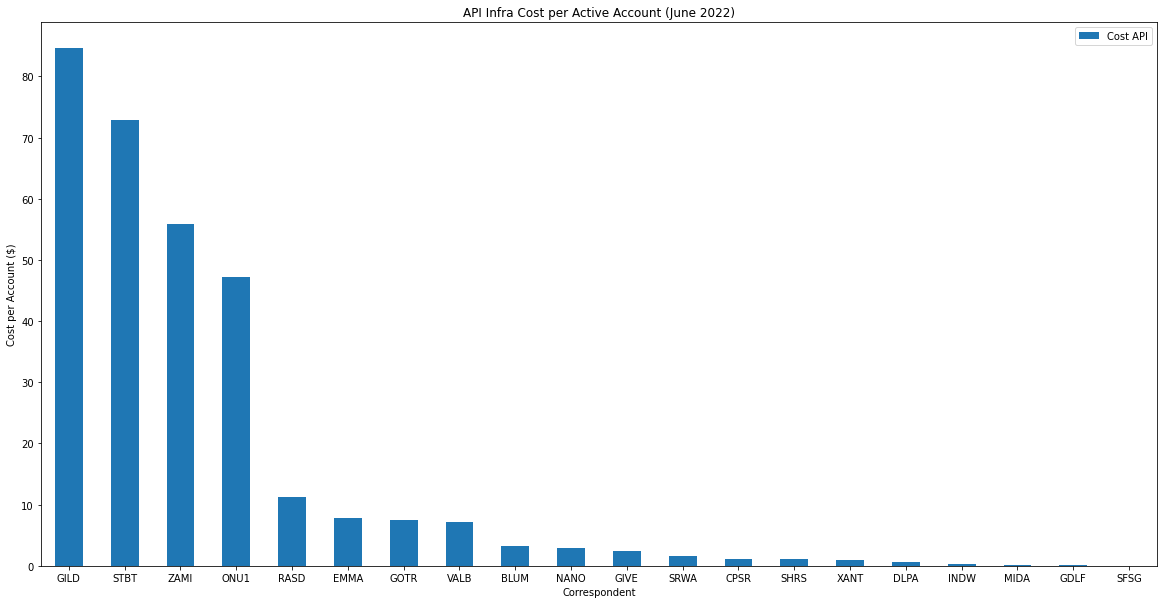

In [184]:
df_june3.sort_values(by=['Cost Product'], ascending = False).plot.bar(x='accounts', y='Cost Product', rot=0, figsize = (20, 10), xlabel = 'accounts', ylabel = 'Cost per Account ($)', \
                      title = 'Product Infra Cost per Active Account (June 2022)')